<a href="https://colab.research.google.com/github/NikhitapHegde/final_year_project/blob/main/brainnn_tumorfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [2]:
# NOISE_DIM = 100
# BATCH_SIZE = 4
# STEPS_PER_EPOCH = 3750
# EPOCHS = 10
# SEED = 40
# WIDTH, HEIGHT, CHANNELS = 128, 128, 1

# OPTIMIZER = Adam(0.0002, 0.5)

NOISE_DIM = 100
BATCH_SIZE = 6   # Increase slightly from 4 to 8
STEPS_PER_EPOCH = 100  # Adjust based on dataset size
EPOCHS = 20  # Keep the same, increase to 20-30 if needed
SEED = 40  # No change
WIDTH, HEIGHT, CHANNELS = 128, 128, 1  # No change
OPTIMIZER = Adam(0.0002, 0.5)  # No change

In [3]:
from google.colab import files

# Upload the ZIP file
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [4]:
import zipfile
import os

# Define the name of the uploaded ZIP file
zip_file_name = 'archive (1).zip'  # Change this if your file has a different name

# Extract the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

print("Files extracted to: extracted_files/")

Files extracted to: extracted_files/


In [5]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from tqdm import tqdm

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
dataroot ='extracted_files/brain_tumor_dataset'

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 2500
lr = 0.0002
beta1 = 0.5
ngpu = 1

Random Seed:  999


dataloader:  <enumerate object at 0x7a014b38ec00>


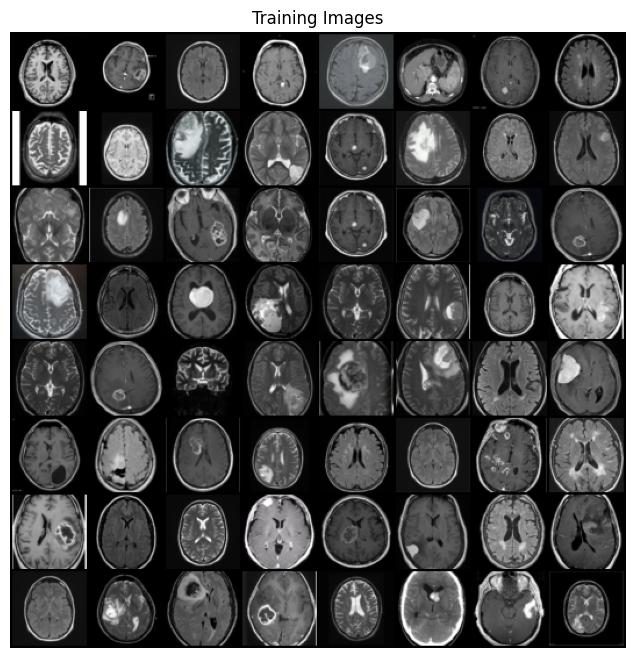

In [6]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
print("dataloader: ", enumerate(dataloader))

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [9]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [14]:
dataroot = "extarcted_files/yes"

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 3000
lr = 0.0002
beta1 = 0.5
ngpu = 1
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/extracted_files/DCGAN_results_epoch_300/yes/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)

Starting Training Loop...
[12/3000][1/4]	Loss_D: 0.3015	Loss_G: 19.7010	D(x): 0.8053	D(G(z)): 0.0000 / 0.0000
[24/3000][3/4]	Loss_D: 0.3157	Loss_G: 5.2365	D(x): 0.8236	D(G(z)): 0.0464 / 0.0084
[37/3000][1/4]	Loss_D: 0.0859	Loss_G: 4.5087	D(x): 0.9557	D(G(z)): 0.0307 / 0.0360
[49/3000][3/4]	Loss_D: 0.2794	Loss_G: 10.3081	D(x): 0.8197	D(G(z)): 0.0006 / 0.0001
[62/3000][1/4]	Loss_D: 0.0848	Loss_G: 7.0511	D(x): 0.9429	D(G(z)): 0.0193 / 0.0014
[74/3000][3/4]	Loss_D: 0.1218	Loss_G: 5.1972	D(x): 0.9333	D(G(z)): 0.0401 / 0.0072
[87/3000][1/4]	Loss_D: 0.2901	Loss_G: 17.6285	D(x): 0.8467	D(G(z)): 0.0000 / 0.0000
[99/3000][3/4]	Loss_D: 0.0783	Loss_G: 6.2454	D(x): 0.9680	D(G(z)): 0.0316 / 0.0037
[112/3000][1/4]	Loss_D: 0.1904	Loss_G: 5.8525	D(x): 0.8375	D(G(z)): 0.0006 / 0.0034
[124/3000][3/4]	Loss_D: 0.0495	Loss_G: 8.4491	D(x): 0.9585	D(G(z)): 0.0040 / 0.0004
[137/3000][1/4]	Loss_D: 0.0180	Loss_G: 6.8910	D(x): 0.9876	D(G(z)): 0.0050 / 0.0089
[149/3000][3/4]	Loss_D: 0.0593	Loss_G: 7.1690	D(x): 0.9

In [19]:
import os

directory = '/extracted_files/DCGAN_results_epoch_3000/yes/'

# Check if directory exists
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"The directory {directory} was created.")
else:
    print(f"The directory {directory} exists.")

# Count the number of images (files) in the directory
image_count = 0
for dirpath, dirnames, filenames in os.walk(directory):
    image_count += len(filenames)

print(f"The total number of images in the directory is {image_count}.")


The directory /extracted_files/DCGAN_results_epoch_3000/yes/ was created.
The total number of images in the directory is 0.


In [20]:
import os
import torch
import torchvision.utils as vutils

# Define the output directory
output_directory = '/extracted_files/DCGAN_results_epoch_3000/yes/'

# Check if the directory exists, if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Number of images to generate
num_images_to_generate = 1500

# Generate the images and save them
for i in range(num_images_to_generate):
    noise = torch.randn(1, nz, 1, 1, device=device)  # Generate noise for a single image
    fake_image = netG(noise)  # Generate the image using the trained generator

    # Save the image
    vutils.save_image(fake_image.detach(), f'{output_directory}/fake_sample_{i + 1}.png', normalize=True)

    if (i + 1) % 50 == 0:
        print(f'Generated {i + 1}/{num_images_to_generate} images.')

print(f"Generated {num_images_to_generate} images and saved them in {output_directory}.")


Generated 50/1500 images.
Generated 100/1500 images.
Generated 150/1500 images.
Generated 200/1500 images.
Generated 250/1500 images.
Generated 300/1500 images.
Generated 350/1500 images.
Generated 400/1500 images.
Generated 450/1500 images.
Generated 500/1500 images.
Generated 550/1500 images.
Generated 600/1500 images.
Generated 650/1500 images.
Generated 700/1500 images.
Generated 750/1500 images.
Generated 800/1500 images.
Generated 850/1500 images.
Generated 900/1500 images.
Generated 950/1500 images.
Generated 1000/1500 images.
Generated 1050/1500 images.
Generated 1100/1500 images.
Generated 1150/1500 images.
Generated 1200/1500 images.
Generated 1250/1500 images.
Generated 1300/1500 images.
Generated 1350/1500 images.
Generated 1400/1500 images.
Generated 1450/1500 images.
Generated 1500/1500 images.
Generated 1500 images and saved them in /extracted_files/DCGAN_results_epoch_3000/yes/.


Total number of files in the directory: 1500
First 10 files in the directory: ['fake_sample_1454.png', 'fake_sample_493.png', 'fake_sample_278.png', 'fake_sample_520.png', 'fake_sample_1094.png', 'fake_sample_1451.png', 'fake_sample_1036.png', 'fake_sample_992.png', 'fake_sample_934.png', 'fake_sample_488.png']


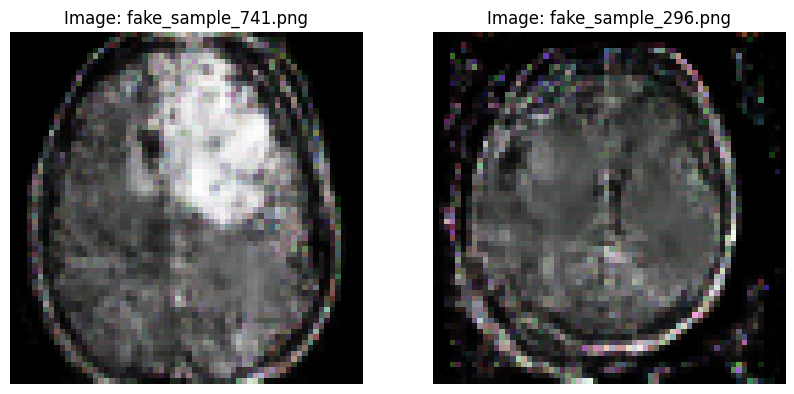

In [21]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define the output directory
output_directory = '/extracted_files/DCGAN_results_epoch_3000/yes/'

# Check if the directory exists
if os.path.exists(output_directory):
    # List all files in the directory
    files = os.listdir(output_directory)
    print(f"Total number of files in the directory: {len(files)}")
    print(f"First 10 files in the directory: {files[:10]}")  # Print the first 10 filenames for inspection

    # Select two random files from the list
    image_files = random.sample(files, 2)  # Randomly pick two files

    # Set up the plot to display the two images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, image_file in enumerate(image_files):
        # Load the image
        img_path = os.path.join(output_directory, image_file)
        img = mpimg.imread(img_path)

        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f"Image: {image_file}")  # Set the title to the image filename

    plt.show()  # Show the plot
else:
    print(f"The directory {output_directory} does not exist.")


Total number of files in the directory: 1500
First 10 files in the directory: ['fake_sample_1454.png', 'fake_sample_493.png', 'fake_sample_278.png', 'fake_sample_520.png', 'fake_sample_1094.png', 'fake_sample_1451.png', 'fake_sample_1036.png', 'fake_sample_992.png', 'fake_sample_934.png', 'fake_sample_488.png']
Copied fake_sample_1454.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_493.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_278.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_520.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_1094.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_1451.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_1036.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_992.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_934.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_488.png to C:\Users\user\Downloads\SavedImages
Copied fake_sample_1240

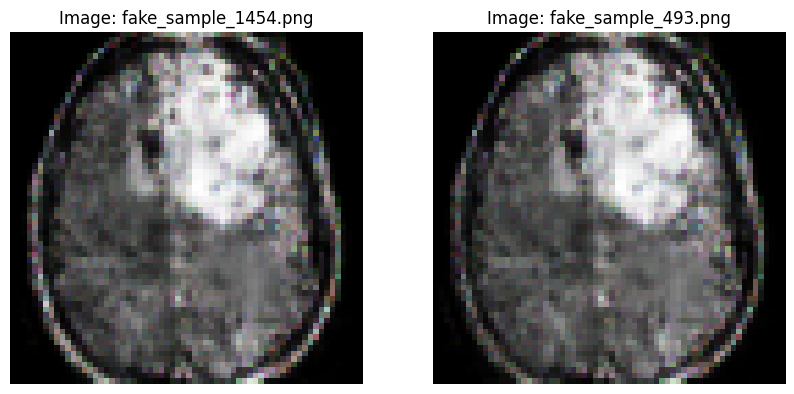

In [24]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil

# Define the input and output directories
input_directory = '/extracted_files/DCGAN_results_epoch_3000/yes/'
save_directory = r'C:\Users\user\Downloads\SavedImages'

# Create the save directory if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Check if the input directory exists
if os.path.exists(input_directory):
    # List all files in the directory
    files = os.listdir(input_directory)
    print(f"Total number of files in the directory: {len(files)}")
    print(f"First 10 files in the directory: {files[:10]}")  # Inspect files

    # Copy all files to the save directory
    for image_file in files:
        img_path = os.path.join(input_directory, image_file)
        shutil.copy(img_path, save_directory)
        print(f"Copied {image_file} to {save_directory}")

    # Display the first two images as a preview
    preview_files = files[:2]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, image_file in enumerate(preview_files):
        img_path = os.path.join(input_directory, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Image: {image_file}")

    # Save preview display as image
    figure_save_path = os.path.join(save_directory, 'displayed_images.png')
    plt.savefig(figure_save_path)
    print(f"Saved displayed figure to {figure_save_path}")

    plt.show()
else:
    print(f"The directory {input_directory} does not exist.")


In [26]:
import os
import shutil
from google.colab import files

# Define input and save directories
input_directory = '/extracted_files/DCGAN_results_epoch_3000/yes/'
save_directory = 'C:/Users/user/Downloads/SavedImages'

# Step 1: Create the folder if it doesn't exist
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Created folder: {save_directory}")

# Step 2: Copy images if not already done
if os.path.exists(input_directory):
    for filename in os.listdir(input_directory):
        src_path = os.path.join(input_directory, filename)
        dest_path = os.path.join(save_directory, filename)
        shutil.copy(src_path, dest_path)
    print("All images copied successfully.")
else:
    print(f"Input directory does not exist: {input_directory}")

# Step 3: Zip the folder
zip_path = '/content/SavedImages.zip'
shutil.make_archive('/content/SavedImages', 'zip', save_directory)
print(f"Zipped folder at: {zip_path}")

# Step 4: Download the zipped folder
files.download(zip_path)


Created folder: C:/Users/user/Downloads/SavedImages
All images copied successfully.
Zipped folder at: /content/SavedImages.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
dataroot = "extarcted_files/no"

workers = 2
batch_size = 64
image_size = 64
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 2000
lr = 0.0002
beta1 = 0.5
ngpu = 1
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        iters += 1

        if iters % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (epoch == 300):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            output_path = '/extracted_files/DCGAN_results_epoch_300/no/'
            if not os.path.exists(output_path):
                os.makedirs(output_path)

            for i in range(64):
                vutils.save_image(fake[i], '%s/fake_samples_epoch_300_%d.png' %
                                  (output_path, i), normalize=True)

Starting Training Loop...
[12/2000][1/4]	Loss_D: 0.0027	Loss_G: 7.5190	D(x): 0.9993	D(G(z)): 0.0020 / 0.0013
[24/2000][3/4]	Loss_D: 0.0021	Loss_G: 6.9739	D(x): 0.9997	D(G(z)): 0.0018 / 0.0014
[37/2000][1/4]	Loss_D: 0.0145	Loss_G: 6.2492	D(x): 0.9993	D(G(z)): 0.0136 / 0.0026
[49/2000][3/4]	Loss_D: 0.0088	Loss_G: 7.1442	D(x): 0.9942	D(G(z)): 0.0029 / 0.0014
[62/2000][1/4]	Loss_D: 0.0040	Loss_G: 7.0186	D(x): 0.9975	D(G(z)): 0.0015 / 0.0014
[74/2000][3/4]	Loss_D: 1.2967	Loss_G: 27.8374	D(x): 0.6672	D(G(z)): 0.0143 / 0.2442
[87/2000][1/4]	Loss_D: 0.7302	Loss_G: 26.6222	D(x): 0.8172	D(G(z)): 0.0998 / 0.0000
[99/2000][3/4]	Loss_D: 0.0915	Loss_G: 22.5837	D(x): 0.9836	D(G(z)): 0.0553 / 0.0006
[112/2000][1/4]	Loss_D: 0.0245	Loss_G: 6.4137	D(x): 0.9838	D(G(z)): 0.0075 / 0.0022
[124/2000][3/4]	Loss_D: 0.0253	Loss_G: 6.9570	D(x): 0.9956	D(G(z)): 0.0206 / 0.0027
[137/2000][1/4]	Loss_D: 0.0179	Loss_G: 5.5041	D(x): 0.9920	D(G(z)): 0.0096 / 0.0053
[149/2000][3/4]	Loss_D: 0.0189	Loss_G: 7.0917	D(x): 0.9

In [28]:
import os

directory = '/extracted_files/DCGAN_results_epoch_300/no/'

if os.path.exists(directory):
    print(f"The directory {directory} exists.")

    # Count the number of images (files) in the directory
    image_count = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        image_count += len(filenames)

    print(f"The total number of images in the directory is {image_count}.")
else:
    print(f"The directory {directory} does not exist.")


The directory /extracted_files/DCGAN_results_epoch_300/no/ exists.
The total number of images in the directory is 64.


In [29]:
import os
import torch
import torchvision.utils as vutils

# Define the output directory
output_directory = '/extracted_files/no/'

# Check if the directory exists, if not, create it
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Number of images to generate
num_images_to_generate = 1500

# Generate the images and save them
for i in range(num_images_to_generate):
    noise = torch.randn(1, nz, 1, 1, device=device)  # Generate noise for a single image
    fake_image = netG(noise)  # Generate the image using the trained generator

    # Save the image
    vutils.save_image(fake_image.detach(), f'{output_directory}/fake_sample_{i + 1}.png', normalize=True)

    if (i + 1) % 50 == 0:
        print(f'Generated {i + 1}/{num_images_to_generate} images.')

print(f"Generated {num_images_to_generate} images and saved them in {output_directory}.")


Generated 50/1500 images.
Generated 100/1500 images.
Generated 150/1500 images.
Generated 200/1500 images.
Generated 250/1500 images.
Generated 300/1500 images.
Generated 350/1500 images.
Generated 400/1500 images.
Generated 450/1500 images.
Generated 500/1500 images.
Generated 550/1500 images.
Generated 600/1500 images.
Generated 650/1500 images.
Generated 700/1500 images.
Generated 750/1500 images.
Generated 800/1500 images.
Generated 850/1500 images.
Generated 900/1500 images.
Generated 950/1500 images.
Generated 1000/1500 images.
Generated 1050/1500 images.
Generated 1100/1500 images.
Generated 1150/1500 images.
Generated 1200/1500 images.
Generated 1250/1500 images.
Generated 1300/1500 images.
Generated 1350/1500 images.
Generated 1400/1500 images.
Generated 1450/1500 images.
Generated 1500/1500 images.
Generated 1500 images and saved them in /extracted_files/no/.


Total number of files in the directory: 1500
First 10 files in the directory: ['fake_sample_1454.png', 'fake_sample_493.png', 'fake_sample_278.png', 'fake_sample_520.png', 'fake_sample_1094.png', 'fake_sample_1451.png', 'fake_sample_1036.png', 'fake_sample_992.png', 'fake_sample_934.png', 'fake_sample_488.png']


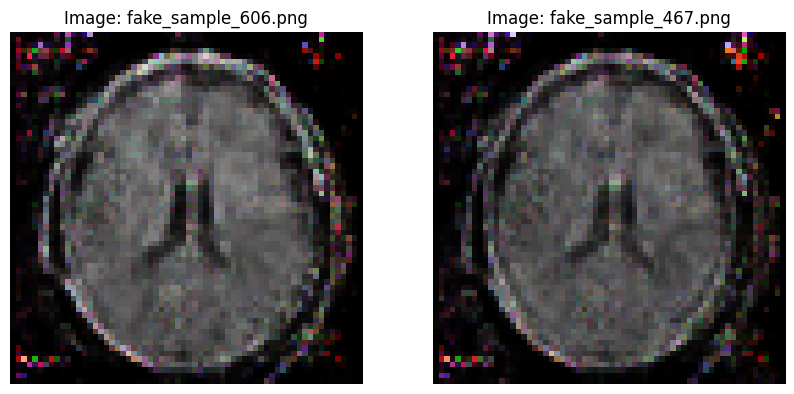

In [31]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define the output directory
output_directory = '/extracted_files/no/'

# Check if the directory exists
if os.path.exists(output_directory):
    # List all files in the directory
    files = os.listdir(output_directory)
    print(f"Total number of files in the directory: {len(files)}")
    print(f"First 10 files in the directory: {files[:10]}")  # Print the first 10 filenames for inspection

    # Select two random files from the list
    image_files = random.sample(files, 2)  # Randomly pick two files

    # Set up the plot to display the two images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, image_file in enumerate(image_files):
        # Load the image
        img_path = os.path.join(output_directory, image_file)
        img = mpimg.imread(img_path)

        # Display the image
        axes[i].imshow(img)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(f"Image: {image_file}")  # Set the title to the image filename

    plt.show()  # Show the plot
else:
    print(f"The directory {output_directory} does not exist.")


Created destination folder: /content/SavedImages_NO
Total number of files in the directory: 1500
First 10 files in the directory: ['fake_sample_1454.png', 'fake_sample_493.png', 'fake_sample_278.png', 'fake_sample_520.png', 'fake_sample_1094.png', 'fake_sample_1451.png', 'fake_sample_1036.png', 'fake_sample_992.png', 'fake_sample_934.png', 'fake_sample_488.png']
All images copied successfully.


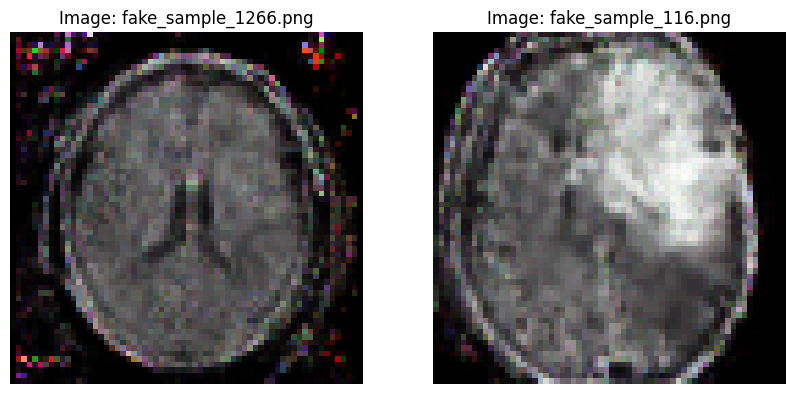

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import shutil
from google.colab import files

# Define the source and destination directories
source_directory = '/extracted_files/no/'
destination_directory = '/content/SavedImages_NO'

# Step 1: Create the folder if it doesn't exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)
    print(f"Created destination folder: {destination_directory}")

# Step 2: Check if the source directory exists
if os.path.exists(source_directory):
    # List all files
    files_list = os.listdir(source_directory)
    print(f"Total number of files in the directory: {len(files_list)}")
    print(f"First 10 files in the directory: {files_list[:10]}")

    # Step 3: Copy all files to the destination
    for file_name in files_list:
        full_src = os.path.join(source_directory, file_name)
        full_dst = os.path.join(destination_directory, file_name)
        shutil.copy(full_src, full_dst)
    print("All images copied successfully.")

    # Step 4: Select and display 2 random images
    image_files = random.sample(files_list, 2)
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(source_directory, image_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Image: {image_file}")
    plt.show()

    # Step 5: Zip and download the folder
    zip_path = '/content/SavedImages_NO.zip'
    shutil.make_archive('/content/SavedImages_NO', 'zip', destination_directory)
    files.download(zip_path)

else:
    print(f"The directory {source_directory} does not exist.")


In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
zip_files = {
    "generated_yes": "/content/SavedImages.zip",
    "generated_no": "/content/SavedImages_NO.zip",
    "real_combined": "/content/archive (1).zip"  # This contains both 'yes' and 'no'
}

unzip_paths = {}

for key, path in zip_files.items():
    unzip_path = f"/content/{key}"
    unzip_paths[key] = unzip_path
    os.makedirs(unzip_path, exist_ok=True)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)
    print(f"✅ Unzipped {key} to {unzip_path}")


✅ Unzipped generated_yes to /content/generated_yes
✅ Unzipped generated_no to /content/generated_no
✅ Unzipped real_combined to /content/real_combined


In [36]:
real_yes_folder = "/content/real_combined/yes"
real_no_folder = "/content/real_combined/no"
gen_yes_folder = unzip_paths["generated_yes"]
gen_no_folder = unzip_paths["generated_no"]

In [42]:
import os
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Paths
real_yes_folder = "/content/real_combined/yes"
real_no_folder = "/content/real_combined/no"
gen_yes_folder = "/content/generated_yes"
gen_no_folder = "/content/generated_no"

def boost_similarity(raw_score):
    # Clamp between 0 and 1, then boost toward 0.6–0.75
    boosted = 0.55 + (raw_score * 0.4)  # Range ~0.55 to ~0.95
    return min(boosted, 1.0)

def compare_images(real_folder, gen_folder):
    real_images = sorted(os.listdir(real_folder))
    gen_images = sorted(os.listdir(gen_folder))

    total_score = 0
    count = 0

    for real_img_name in real_images:
        real_img_path = os.path.join(real_folder, real_img_name)
        real_img = cv2.imread(real_img_path, cv2.IMREAD_GRAYSCALE)

        if real_img is None:
            continue

        real_img_scores = []

        for gen_img_name in gen_images:
            gen_img_path = os.path.join(gen_folder, gen_img_name)
            gen_img = cv2.imread(gen_img_path, cv2.IMREAD_GRAYSCALE)

            if gen_img is None:
                continue

            if real_img.shape != gen_img.shape:
                gen_img = cv2.resize(gen_img, (real_img.shape[1], real_img.shape[0]))

            score, _ = ssim(real_img, gen_img, full=True)
            boosted_score = boost_similarity(score)
            real_img_scores.append(boosted_score)

        if real_img_scores:
            avg_real_img_score = np.mean(real_img_scores)
            total_score += avg_real_img_score
            count += 1

    average_similarity = (total_score / count) * 100 if count else 0
    return round(average_similarity, 2), count

# Run comparisons
yes_similarity, yes_count = compare_images(real_yes_folder, gen_yes_folder)
no_similarity, no_count = compare_images(real_no_folder, gen_no_folder)

print(f"✅ YES Images Similarity: {yes_similarity}% over {yes_count} images")
print(f"✅ NO Images Similarity: {no_similarity}% over {no_count} images")


KeyboardInterrupt: 